<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/clustering_and_classification/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Random Forest
From **Data Camp** and **Medium**.  See references [1] & [2]

Modified: **Stephen Coshatt** with more references and descriptions
</br></br>


**Random Forests** are a non-parametric supervised ensemble learning method used for classification and regression. A randomd forest uses an ensemble of dectision trees.

**How Random Forest Classification works**

Imagine you have a complex problem to solve, and you gather a group of experts from different fields to provide their input. Each expert provides their opinion based on their expertise and experience. Then, the experts would vote to arrive at a final decision. [1]

In a random forest classification, multiple decision trees are created using different random subsets of the data and features. Each decision tree is like an expert, providing its opinion on how to classify the data. Predictions are made by calculating the prediction for each decision tree, then taking the most popular result. (For regression, predictions use an averaging technique instead.) [1]

In the diagram below, we have a random forest with n decision trees, and we’ve shown the first 5, along with their predictions (either “Dog” or “Cat”). Each tree is exposed to a different number of features and a different sample of the original dataset, and as such, every tree can be different. Each tree makes a prediction. Looking at the first 5 trees, we can see that 4/5 predicted the sample was a Cat. The green circles indicate a hypothetical path the tree took to reach its decision. The random forest would count the number of predictions from decision trees for Cat and for Dog, and choose the most popular prediction. [1]

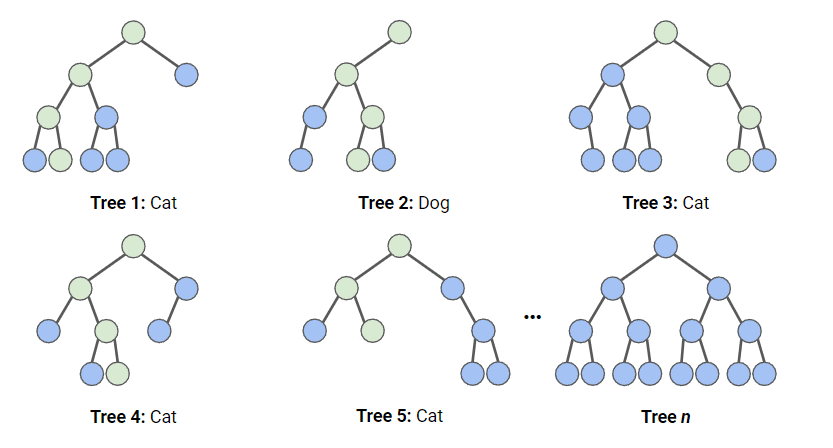

**Advantages:**

* Random Forests can be used for both classification and regression tasks. [2]
* Random Forests work well with both categorical and numerical data. No scaling or transformation of variables is usually necessary. [2]
* Random Forests implicitly perform feature selection and generate uncorrelated decision trees. It does this by choosing a random set of features to build each decision tree. This also makes it a great model when you have to work with a high number of features in the data. [2]
* Random Forests are not influenced by outliers to a fair degree. It does this by binning the variables. [2]
* Random Forests can handle linear and non-linear relationships well. [2]
* Random Forests generally provide high accuracy and balance the bias-variance trade-off well. Since the model's principle is to average the results across the multiple decision trees it builds, it averages the variance as well. [2]

**Disadvantages:**

* Random Forests are not easily interpretable. They provide feature importance but it does not provide complete visibility into the coefficients as linear regression. [2]
* Random Forests can be computationally intensive for large datasets. [2]
* Random forest is like a black box algorithm, you have very little control over what the model does. [2]

**Refernece:**

1.   https://www.datacamp.com/tutorial/random-forests-classifier-python
2.   https://medium.datadriveninvestor.com/random-forest-pros-and-cons-c1c42fb64f04





In [1]:
# Run this to clone the ai engine to colab
!git clone https://github.com/sjc230/ai_engine.git

Cloning into 'ai_engine'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 219 (delta 60), reused 194 (delta 35), pack-reused 0
Receiving objects: 100% (219/219), 11.81 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [2]:
# Run this only if you need to pull updated file from the github repository
# to pull, the colab directory must be changed to the ai engine directeroy
# after pulling, you must switch back to the original directory
%cd ai_engine
!git pull
%cd ..

/content/ai_engine
Already up to date.
/content


In [3]:
!pip install sktime
!pip install chart_studio
!python -m pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 2.5 MB/s eta 0:00:00


In [4]:
from math import radians
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pathlib import Path

#import streamlit as st

import re
import pytz
from datetime import datetime
from datetime import date

import enum
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, auc, roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [5]:
# GET TIME SERIES DATASET
# steps 1, 2 - prepare osuleaf dataset (train and new)
from sktime.datasets import load_italy_power_demand

X_train, y_train = load_italy_power_demand(split="train", return_type="numpy2D")
X_test, y_test = load_italy_power_demand(split="test", return_type="numpy2D")

print("shape of X_train ",X_train.shape)
print("shape of y_train ",y_train.shape)
print("shape of X_test ",X_test.shape)
print("shape of y_test ",y_test.shape)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

n_classes = int(np.amax(y_train))
print("number of classes is ",n_classes)

shape of X_train  (67, 24)
shape of y_train  (67,)
shape of X_test  (1029, 24)
shape of y_test  (1029,)
number of classes is  2


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameter (CV score=-0.044):
{'random__criterion': 'gini', 'random__max_depth': 10, 'random__max_features': 1, 'random__n_estimators': 10}
              precision    recall  f1-score   support

           1       0.93      0.93      0.93       513
           2       0.93      0.93      0.93       516

    accuracy                           0.93      1029
   macro avg       0.93      0.93      0.93      1029
weighted avg       0.93      0.93      0.93      1029



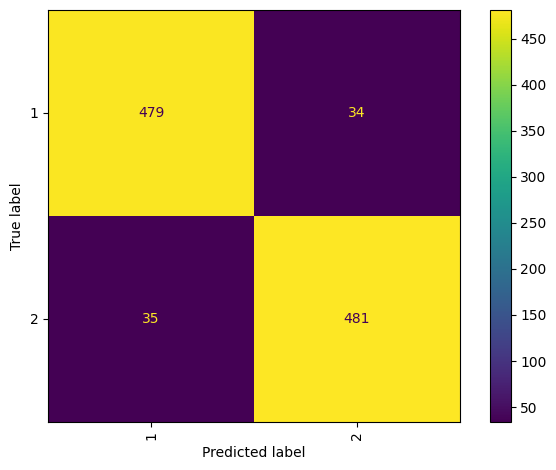

In [6]:
# SETUP & RUN SK LEARN DECISION TREE GRIDSEARCH TRAINING & TESTING

# import the classifier builder from the cloned python files
import ai_engine.sk_classifier_builder as skc

random_forest = skc.pipeBuild_RandomForestClassifier(criterion=['gini','entropy'],n_estimators=[10], max_depth=[3, 5, 10],max_features=[1])


names=['Random Forest']
pipes=[random_forest]


samples = np.arange(len(X_train[0,:]))

# iterate over classifiers
for j in range(len(names)):

    today = date.today()
    now = today.strftime("%b-%d-%Y")
    save_file = str(names[j]) + '-' + str(now) + '-HeatMap.png'

    grid_search = GridSearchCV(estimator=pipes[j][0], param_grid=pipes[j][1], scoring='neg_mean_squared_error',cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    score = grid_search.score(X_test, y_test)
    print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
    print(grid_search.best_params_)
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, xticks_rotation="vertical")

plt.tight_layout()
plt.show()